# 1. Setup

In [1]:
import pickle
from time import time

from lightgbm import LGBMRegressor, plot_tree
from matplotlib.patches import Patch
import plotly.express as px
from pqdm.processes import pqdm
from scipy.optimize import curve_fit
from scipy.stats import entropy
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sklearn as skl

from utils import *

# 2. Prepare data

## 2.1. Trips

In [2]:
trips = pd.read_parquet('../data/trips2.parquet').disp()

492,448 rows x 8 cols; Memory: 13.6 MiB


,Distance,Time,Speed,Mode,Purpose,LongStay,ODUrban,SES
,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>
0,8.439379,16.182075,31.291583,Drive,Other,No,S → S,Mid


## 2.2. Factor combinations

In [3]:
def get_comb_hist(**comb):
    res = []
    min_samples = comb.pop('min_samples', np.inf)
    query = ' & '.join([f'{k}=="{v}"' for k, v in
                        comb.items() if v != 'Overall'])
    df = trips.query(query) if query else trips
    if len(df) <= min_samples:
        return res
    for target, vmax in D(Distance=100, Time=90).items():
        y = df[target].pipe(lambda x: x[x <= vmax])
        y, x = np.histogram(y, bins=np.arange(0, vmax + 0.1))
        y = (1 - (y / y.sum()).cumsum()).clip(0)
        beta = -curve_fit(lambda x, b: np.exp(b * x), x[1:], y)[0][0]
        res.append(D(Target=target) | comb | D(Beta=beta))
    return res

In [4]:
def get_factor_combs(n_min=100, njobs=20, trips=trips, overwrite=False):
    outpath = Path('../data/factor_combs_2.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    cols = list(trips.loc[:, 'Mode':].columns)
    combs = it.product(*[['Overall'] + list(
            trips[col].cat.categories) for col in cols])
    kwargs = (D(zip(cols, x)) | D(min_samples=n_min) for x in combs)
    tot = np.prod([trips[x].cat.categories.size + 1 for x in cols])
    df = pqdm(kwargs, get_comb_hist, n_jobs=njobs,
              argument_type='kwargs', total=tot)
    df = Pdf(sum(df, [])).astype(D(Target=CAT, Beta=np.float32))
    for col in cols:
        df[col] = ordered_factor(df[col])
    df.to_parquet(mkfile(outpath))
    return df

combs = get_factor_combs(overwrite=1).disp() # t=0:06
# x = get_factor_combs(overwrite=1); x # t=2:05

QUEUEING TASKS | :   0%|          | 0/1680 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1680 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1680 [00:00<?, ?it/s]

1,948 rows x 7 cols; Memory: 0.0 MiB


,Target,Mode,Purpose,LongStay,ODUrban,SES,Beta
,<category>,<category>,<category>,<category>,<category>,<category>,<float32>
0,Distance,Overall,Overall,Overall,Overall,Overall,0.094919


In [5]:
combs.loc[:, 'Mode': 'SES'].apply(Series.value_counts).fillna(0).astype(int).replace(0, '').T

,Bike,Drive,High,Low,Mid,No,Other,Overall,R → R,R ↔ U,S → S,S ↔ R,Shopping,Transit,U → U,U ↔ S,Walk,Work,Yes
Mode,218,548,,,,,,554,,,,,,296,,,332,,
Purpose,,,,,,,522,588,,,,,408,,,,,430,
LongStay,,,,,,788,,794,,,,,,,,,,,366
ODUrban,,,,,,,,388,254,130,320,188,,,356,312,,,
SES,,,528,250,564,,,606,,,,,,,,,,,


In [6]:
def get_overall_beta(combs=combs):
    res = []
    cols = list(combs.loc[:, 'Mode': 'SES'].columns)
    for trg, df in combs.groupby('Target'):
        for col in cols:
            d = df[df[col] != 'Overall'][cols]
            idx = d[(d.drop(columns=col) == 'Overall').all(1)].index
            d = df.loc[idx, [col, 'Beta']].rename(columns={col: 'Level'})
            res.append(d.assign(Factor=col, Target=trg))
    res = pd.concat(res).rename_axis('row_id')
    return res

overalls = get_overall_beta().disp()
# x = get_overall_beta(); x

36 rows x 4 cols; Memory: 0.0 MiB


,Level,Beta,Factor,Target
row_id,<object>,<float32>,<object>,<object>
554,Drive,0.085412,Mode,Distance


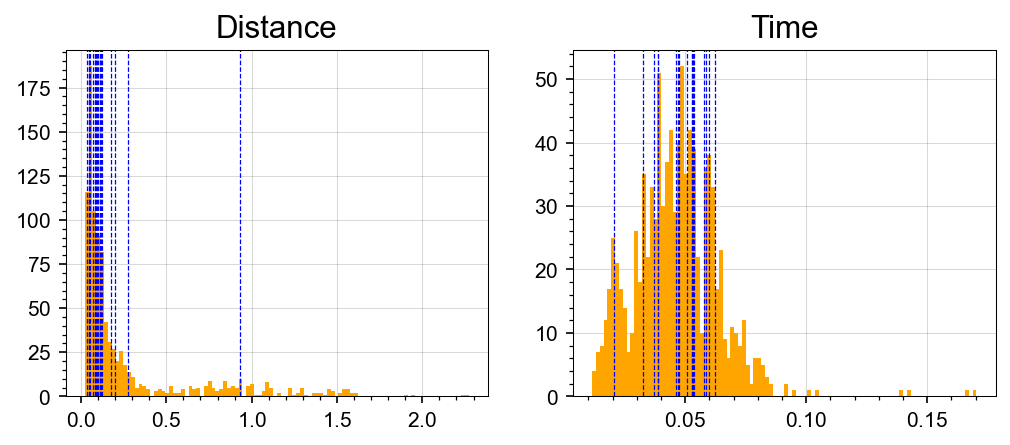

In [37]:
def plot_beta(combs=combs):
    _, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
    for i, (trg, df) in enumerate(combs.groupby('Target')):
        ax = pplot(axes[i], title=trg)
        df.Beta.hist(bins=100, color='orange', ax=ax)
        for _, r in overalls.query(f'Target=="{trg}"').iterrows():
            ax.axvline(r.Beta, color='b', ls='--', lw=0.6)

x = plot_beta(); x

## Important combinations

In [ ]:
# imp_combs = (
#     # (Mode, Purpose, LongStay, ODUrban, SES)
#     ('Drive', 'Work', 'Yes', 'R → R', 'Low'),
#     ('Drive', 'Work', 'No', 'R → R', 'Low'),
#     ('Drive', 'Shopping', 'Yes', 'R → R', 'Low'),
#     ('Drive', 'Shopping', 'No', 'R → R', 'Low'),
#     ('Drive', 'Other', 'Yes', 'R → R', 'Low'),
#     ('Drive', 'Other', 'No', 'R → R', 'Low'),
#     ('Drive', 'Work', 'Yes', 'R → R', 'Low'),
#     ('Drive', 'Work', 'Yes', 'R → R', 'Low'),
#     ('Drive', 'Work', 'Yes', 'R → R', 'Low'),
# )

# 3. Modeling for SHAP

## 3.1. Test models

In [8]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor

In [9]:
models = (
    ## Linear models
    ('Linear Regression', LinearRegression(), D(
        fit_intercept=[True, False],
    )),
    ('Bayesian Ridge',
     BayesianRidge(max_iter=1000),
     D(alpha_1=[.5e-6, 1e-6, 2e-6],
       alpha_2=[.5e-6, 1e-6, 2e-6],
       lambda_1=[.5e-6, 1e-6, 2e-6],
       lambda_2=[.5e-6, 1e-6, 2e-6],
    )),
    ('SGD Regression', SGDRegressor(max_iter=1000), D(
        alpha=[1e-05, 0.0001, 0.001, 0.01],
        l1_ratio=[0.1, 0.15, 0.2, 0.3],
        penalty=['l2', 'elasticnet'],
    )),
    ## Kernel models
    ('Linear SVR', LinearSVR(dual='auto', max_iter=50_000), D(
        C=[0.5, 0.75, 1.0, 1.25, 1.5],
        epsilon=[0, 0.1, 0.2],
        loss=['epsilon_insensitive', 'squared_epsilon_insensitive']
    )),
    ## Decision tree models
    ('Random Forest',
     RandomForestRegressor(n_jobs=6, random_state=SEED),
     D(n_estimators=[100, 200, 300], max_depth=[10, 20, 30, 40],
    )),
    ('Light Gradient Boost',
     LGBMRegressor(n_jobs=6, force_row_wise=True, verbosity=-1,
                   random_state=SEED, num_leaves=1000),
     D(learning_rate=[0.05, 0.1, 0.5], max_depth=[10, 20, 30, 40],
       n_estimators=[100, 200, 500, 750],
    )),
    ('Extreme Gradient Boost',
     XGBRegressor(n_jobs=6, verbosity=0, random_state=SEED),
     D(booster=['gbtree', 'gblinear'], learning_rate=[0.05, 0.1, 0.5],
       n_estimators=[100, 200, 500, 750],
    )),
)

## 3.2. Select best estimators using CV

In [10]:
metrics = D(r2=r2_score, mae=mean_absolute_error, mape=mean_absolute_percentage_error, mse=mean_squared_error)

In [38]:
def cross_validate(combs=combs, models=models, metrics=metrics,
                   test_ratio=0.3, njobs=1, overwrite=False):
    outpath = Path('../data/comb_models.pickle')
    if outpath.exists() and not overwrite:
        return pd.read_pickle(outpath)
    res = []
    pbar = tqdm(list(it.product(models, ['Distance', 'Time'])))
    for (name, model, params), target in pbar:
        t = time()
        df = combs.query(f'Target=="{target}"')
        X = pd.get_dummies(df.iloc[:, 1:-1])
        Xtrain, Xtest, ytrain, ytest = train_test_split(
            X, 1 / df['Beta'], test_size=test_ratio, random_state=SEED)
        cv = GridSearchCV(model, params, cv=5, n_jobs=njobs, scoring='r2')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            cv.fit(Xtrain, ytrain)
        row = D(target=target, family=name, model=cv.best_estimator_,
                params=cv.best_params_)
        ypred = cv.best_estimator_.predict(Xtest)
        for metric, func in metrics.items():
            row[metric] = func(ytest, ypred)
        res.append(row | D(runtime=time() - t))
    res = Pdf(res)
    res.to_pickle(mkfile(outpath))
    return res

cv_df = cross_validate(njobs=12, overwrite=1).disp() # t=0:31
# x = cross_validate(njobs=12, overwrite=1); x # t=9:17

  0%|          | 0/14 [00:00<?, ?it/s]

14 rows x 9 cols; Memory: 0.0 MiB


,target,family,model,params,r2,mae,mape,mse,runtime
,<object>,<object>,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>
0,Distance,Linear Regression,LinearRegression(fit_intercept=False),{'fit_intercept': False},0.871989,2.22339,0.575233,9.772407,1.978878


In [12]:
(cv_df.assign(family=ordered_factor(cv_df.family))
 .drop(columns=['model', 'params', 'runtime'])
 .melt(['target', 'family'], var_name='metric')
 .assign(metric=lambda x: x.metric.str.upper())
 .rename(columns=str.title)
 .pivot_table('Value', 'Family', ['Target', 'Metric'])
 .reset_index())

Target                  Family  Distance                                \
Metric                               MAE      MAPE       MSE        R2   
0            Linear Regression  0.073362  0.625559  0.012218  0.878236   
1               Bayesian Ridge  0.073156  0.623315  0.012148  0.878939   
2               SGD Regression  0.070073  0.615379  0.011434  0.886052   
3                   Linear SVR  0.073067  0.622950  0.012115  0.879264   
4                Random Forest  0.015940  0.073310  0.001141  0.988630   
5         Light Gradient Boost  0.017202  0.113710  0.001038  0.989656   
6       Extreme Gradient Boost  0.012190  0.067809  0.000743  0.992591   

Target      Time                                
Metric       MAE      MAPE       MSE        R2  
0       0.006112  0.145699  0.000079  0.676798  
1       0.006074  0.143899  0.000078  0.680899  
2       0.007067  0.170790  0.000095  0.611271  
3       0.006071  0.144124  0.000078  0.680817  
4       0.001575  0.034660  0.000007  0.972861  
5       0.001556  0.036769  0.000005  0.977869  
6       0.001744  0.038491  0.000007  0.971487

# 4. SHAP analysis

## 4.1. Compute values

In [13]:
def get_shap(combs=combs, cv=cv_df, overwrite=False):
    outpath = Path('../data/comb_shap_levels.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    models = cv.query('family == "Extreme Gradient Boost"')
    for target, df in combs.groupby('Target'):
        X = pd.get_dummies(df.iloc[:, 1:-1]).rename_axis('row_id')
        model = models.query(f'target=="{target}"').iloc[0].model
        explainer = shap.TreeExplainer(model, seed=SEED)
        shaps = explainer(X).values
        d = Pdf(shaps, columns=X.columns, index=X.index)
        d.insert(0, 'Target', target)
        res.append(d)
    res = pd.concat(res).astype(D(Target=CAT))
    # res = res.reset_index(drop=1).rename_axis('row_id')
    res.to_parquet(mkfile(outpath))
    return res

shaps = get_shap(overwrite=1).disp() # t=0:05
# x = get_shap(overwrite=1); x

[09:38:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:38:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


1,948 rows x 24 cols; Memory: 0.2 MiB


,Target,Mode_Overall,Mode_Drive,Mode_Transit,Mode_Walk,Mode_Bike,Purpose_Overall,Purpose_Work,Purpose_Shopping,Purpose_Other,...,ODUrban_U → U,ODUrban_S → S,ODUrban_R → R,ODUrban_U ↔ S,ODUrban_S ↔ R,ODUrban_R ↔ U,SES_Overall,SES_Low,SES_Mid,SES_High
row_id,<category>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,Distance,0.007184,-0.000203,0.003611,-0.161287,-0.020989,0.000607,0.002939,-0.016805,-0.000685,...,-0.016917,-0.003153,-0.002843,0.00496,0.005962,0.004036,-0.002496,-0.009782,-0.003169,0.004745


# 5. Reduce factor combinations

## 5.1. Feature contribution

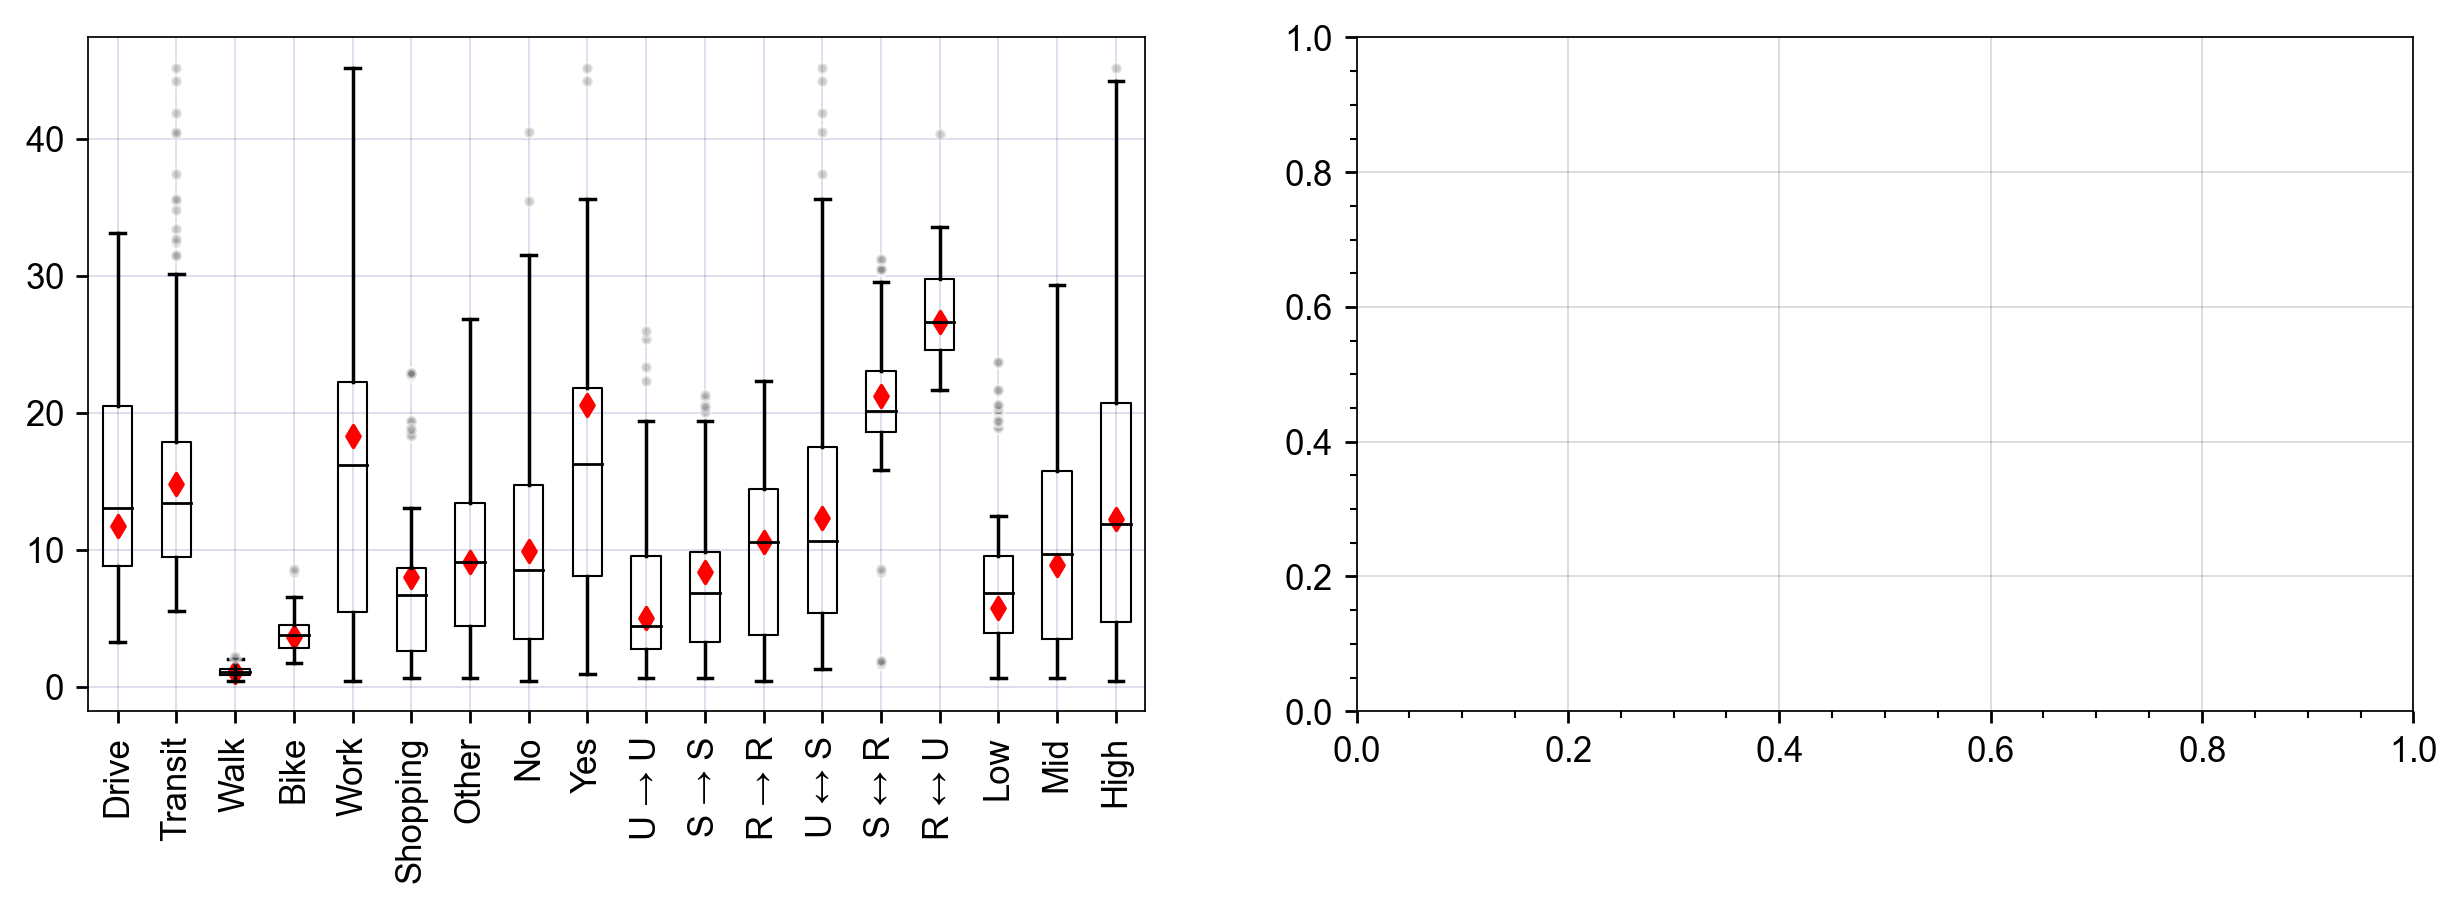

In [67]:
def fit_comb_curves(shaps=shaps, combs=combs, overalls=overalls, delta=2, dpi=150):
    factors = Series([x.split('_')[0] for x in 
                      shaps.iloc[:, 1:].columns]).drop_duplicates()
    # colors = D(zip(factors, sns.color_palette(cmap, len(factors)).as_hex()))
    _, axes = plt.subplots(1, 2, figsize=(12, 3.5), dpi=dpi)
    for i, (target, amax) in enumerate([
            ('Distance', 40), ('Time', 60)]):
        ax = pplot(axes[i], xminor=0, yminor=0, gridcolor='navy')
        pts = combs.query(f'Target=="{target}"').copy()
        pts['Area'] = 1 / pts.Beta
        lvl = sum([[(col, level, df.Area) for level, df in pts.groupby(col)
                    if level != 'Overall'] for col in factors], [])
        lvl = Pdf(lvl, columns=['Factor', 'Level', 'Areas'])
        overall = (overalls.query(f'Target=="{target}"').reset_index()
                   .assign(Overall=lambda df: 1 / df.Beta))
        lvl = lvl.merge(overall[['Factor', 'Level', 'row_id', 'Overall']])
        ax.boxplot(lvl.Areas, positions=range(len(lvl)), boxprops=D(lw=0.6),
                   flierprops=D(markersize=3, linewidth=0, alpha=0.4,
                                markeredgecolor='w', markerfacecolor='grey'),
                   medianprops=D(color='k', lw=0.8))
        ax.scatter(lvl.Level, lvl.Overall, marker='d', s=20, color='r')
        ax.set_xticklabels(lvl.Level, rotation=90)
        return
        for col in factors:
            others = [f'{x}=="Overall"' for x in set(factors) - {col}]
            for _, r in df.query(' & '.join(others)).iterrows():
                if r[col] == 'Overall' or r.Beta > bmax:
                    continue
                x = levels.query(f'factor=="{col}" & level=="{r[col]}"').iloc[0]
                twin.scatter(x.idx, r.Beta, marker='d', c='r', s=15)
        overall = df.query(' & '.join([f'{x}=="Overall"' for x in factors]))
        ax.axhline(1 / overall.iloc[0].Beta, ls='--', lw=0.8, color='k')
        ax.legend(handles=[mpl.patches.Patch(label=k, color=v)
                             for k, v in colors.items()],
                    loc=1, framealpha=1, facecolor='w', edgecolor='#555')
    plt.tight_layout()

x = fit_comb_curves(dpi=250); x

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


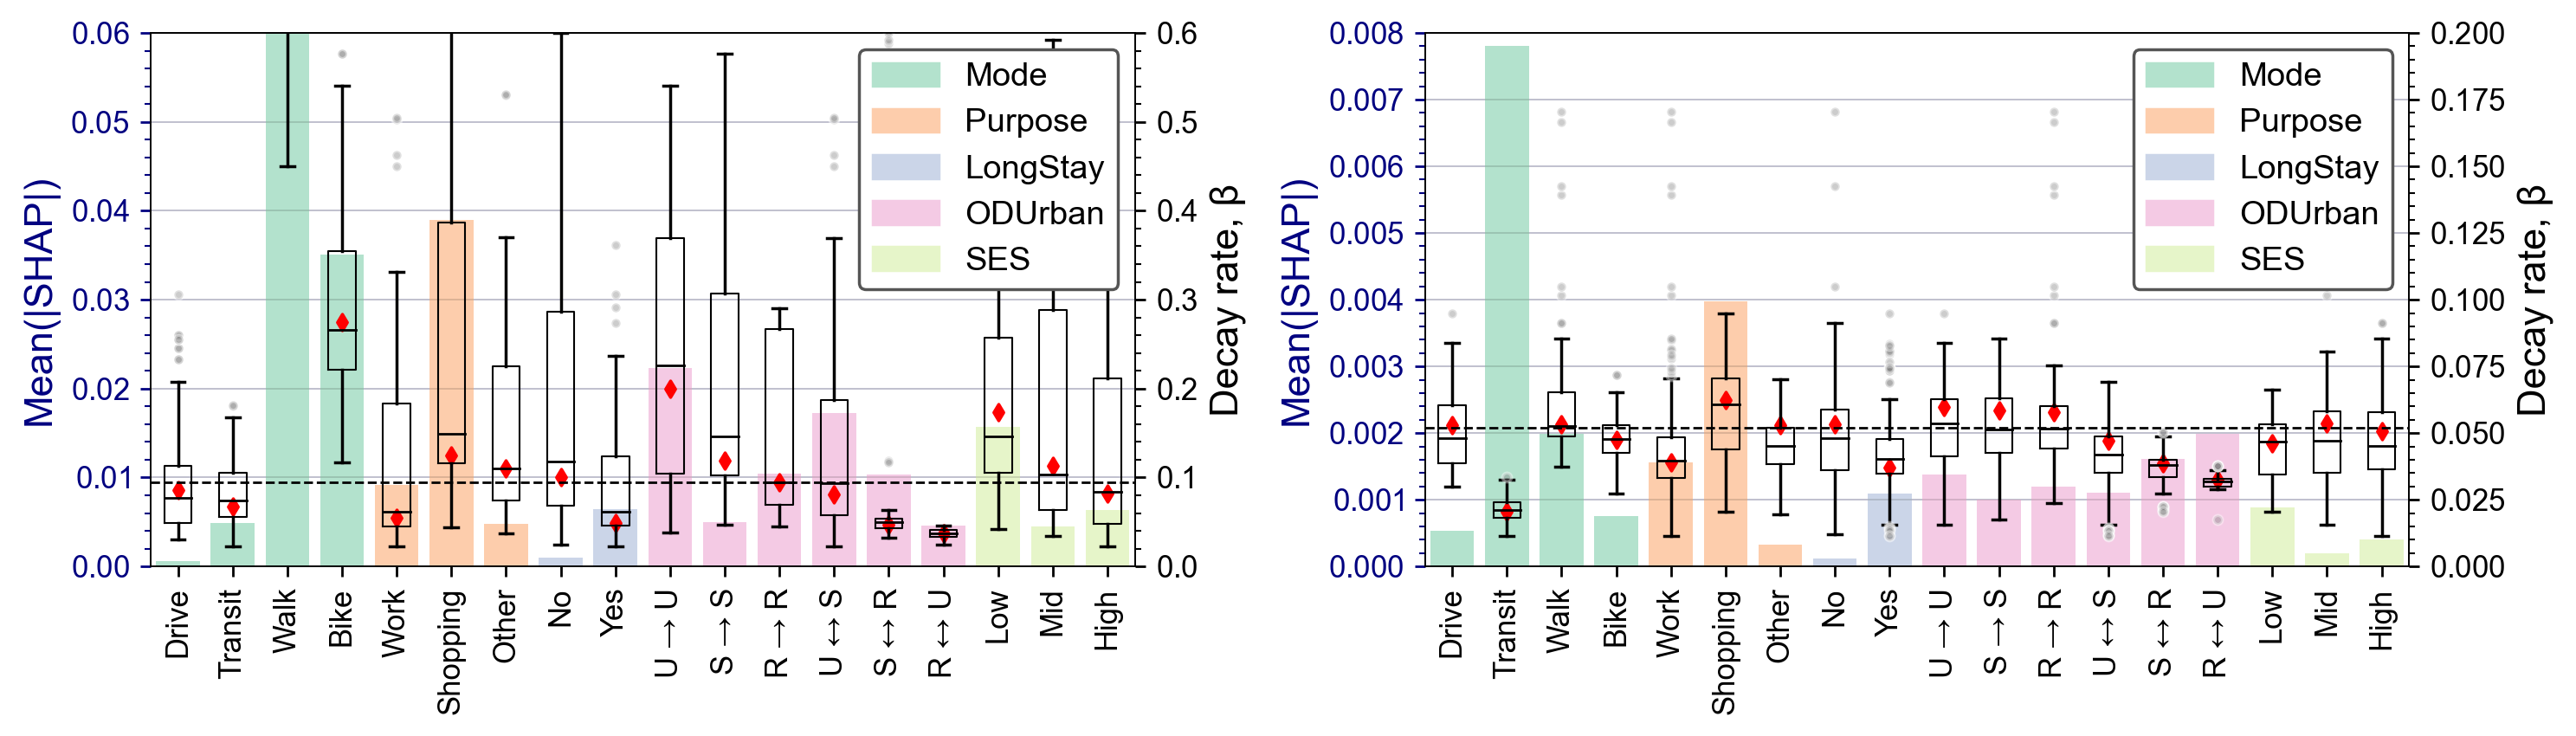

In [14]:
def fit_comb_curves(shaps=shaps, combs=combs, dpi=150, cmap='Pastel2'):
    factors = Series([x.split('_')[0] for x in 
                      shaps.iloc[:, 1:].columns]).drop_duplicates()
    colors = D(zip(factors, sns.color_palette(cmap, len(factors)).as_hex()))
    _, axes = plt.subplots(1, 2, figsize=(12, 3.5), dpi=dpi)
    for i, (target, bmax, max_shap) in enumerate([
            ('Distance', 0.6, 0.06), ('Time', 0.2, 0.008)]):
        ## SHAP contribution
        df = shaps.query(f'Target=="{target}"').drop(columns='Target')
        df = np.abs(df).mean().rename('contrib').reset_index()
        df['factor'], df['level'] = [ordered_factor(x) for x in 
                                     zip(*df.pop('index').str.split('_'))]
        df = df[df.level != 'Overall'].reset_index(drop=1)
        df['color'] = df.factor.map(colors)
        ax = pplot(axes[i], xminor=0, ylim=(0, max_shap), yminor=0, gridcolor='navy')
        ax.bar(df.level, df.contrib, color=df.color, alpha=1)
        levels = df[['factor', 'level']].rename_axis('idx').reset_index()
        ax.set_xticklabels(df.level, rotation=90)
        ax.tick_params(axis='y', which='both', colors='navy')
        ax.grid(False, axis='x')
        ax.set_ylabel('Mean(|SHAP|)', color='navy')
        ## Parameters
        twin = pplot(ax.twinx(), ylab='Decay rate, β', yminor=0, ylim=(0, bmax))
        df = combs.query(f'Target=="{target}"')
        betas = sum([[d.Beta for level, d in df.groupby(col)
                      if level != 'Overall'] for col in factors], [])
        twin.boxplot(
            betas, positions=range(len(betas)),
            boxprops=D(lw=0.6),
            flierprops=D(markersize=3, linewidth=0, alpha=0.4,
                         markeredgecolor='w', markerfacecolor='grey'),
            medianprops=D(color='k', lw=0.8))
        for col in factors:
            others = [f'{x}=="Overall"' for x in set(factors) - {col}]
            for _, r in df.query(' & '.join(others)).iterrows():
                if r[col] == 'Overall' or r.Beta > bmax:
                    continue
                x = levels.query(f'factor=="{col}" & level=="{r[col]}"').iloc[0]
                twin.scatter(x.idx, r.Beta, marker='d', c='r', s=15)
        overall = df.query(' & '.join([f'{x}=="Overall"' for x in factors]))
        twin.axhline(overall.iloc[0].Beta, ls='--', lw=0.8, color='k')
        twin.legend(handles=[mpl.patches.Patch(label=k, color=v)
                             for k, v in colors.items()],
                    loc=1, framealpha=1, facecolor='w', edgecolor='#555')
    plt.tight_layout()

x = fit_comb_curves(dpi=250); x

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


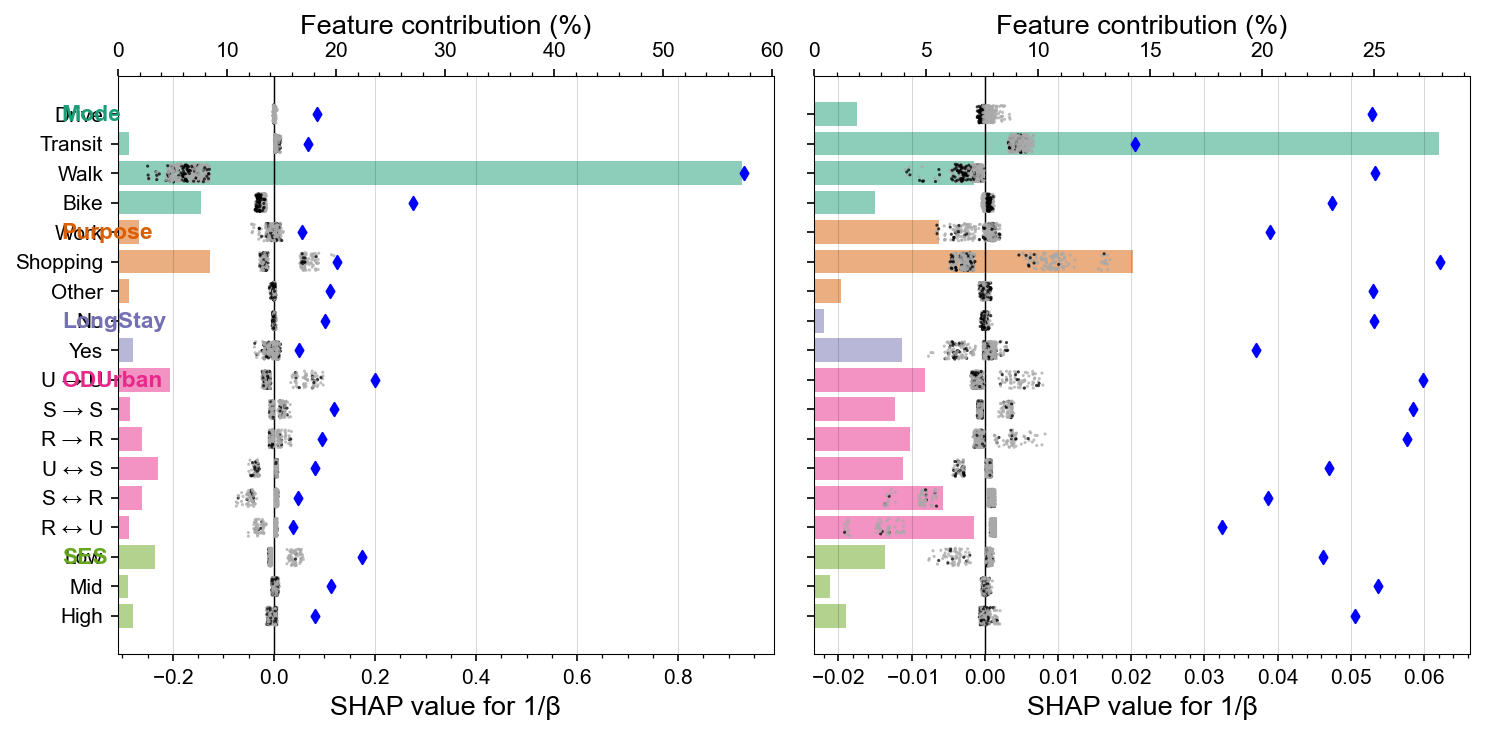

In [32]:
def fig_shap_contrib(shaps=shaps, combs=combs, overalls=overalls,
                     size=(10, 5), dpi=150, cmap='Dark2'):
    cols = list(combs.iloc[:, 1:-1].columns)
    X = pd.get_dummies(combs.set_index('Target')[cols])
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    col_colors = D(zip(cols, sns.color_palette(cmap, len(cols)).as_hex()))
    pt_colors = sns.color_palette(['darkgrey', 'k'])
    for i, (target, df) in enumerate(shaps.groupby('Target')):
        ## Beeswarm plot
        df = df.drop(columns='Target').copy().rename_axis('row')
        df = df.assign(var='shap').rename_axis('row')
        vals = X.loc[target].astype(int).reset_index(drop=1)
        vals = vals.assign(var='present').rename_axis('row')
        df = pd.concat([df, vals]).reset_index().melt(['row', 'var'])
        df = df[~df.variable.str.endswith('Overall')]
        df = df.pivot_table('value', ['row', 'variable'], 'var').reset_index()
        df.variable = (pd.Categorical(df.variable, categories=vals.columns)
                       .remove_unused_categories())
        df = df.sort_values(['variable', 'row']).reset_index(drop=1)
        df['factor'], df['level'] = [ordered_factor(x) for x in 
                                     zip(*df.variable.str.split('_'))]
        ovrl = overalls.query(f'Target=="{target}"').rename_axis('row')
        ovrl = df.merge(ovrl, on='row').query('Level==level')
        sns.stripplot(df, ax=axes[i], x='shap', y='level', hue='present',
                      alpha=0.75, dodge=0, size=1.5, jitter=0.3,
                      palette=pt_colors, legend=False)
        ax = pplot(axes[i], xlab='SHAP value for 1/β', ylab='', yminor=0)
        ax.scatter(ovrl.Beta, ovrl.Level, marker='d', color='b', s=20)
        # ax.scatter(ovrl.Beta, ovrl.Level, s=10, marker='d', color='b')
        ax.axvline(0, ls='-', color='k', lw=0.7)
        ax.set_zorder(1); ax.patch.set_visible(False)
        ax.set_yticklabels(df.level.cat.categories)
        ## Feature contributions
        df = df.assign(contrib=np.abs(df.shap))
        df = df.groupby('variable').contrib.mean().reset_index()
        df.contrib /= df.contrib.sum() / 100
        df['factor'], df['level'] = [ordered_factor(x) for x in 
                                     zip(*df.pop('variable').str.split('_'))]
        df = df[df.level != 'Overall'].reset_index(drop=1)
        df['color'] = df.factor.map(col_colors)
        twin = pplot(ax.twiny(), xlab='Feature contribution (%)', xminor=0)
        twin.barh(df.level, df.contrib, color=df.color, alpha=0.5)
        twin.grid(False, axis='x')
        if i == 0:
            # ax.legend(title='Feature value', handles=[
            #     mpl.lines.Line2D([0], [0], color='none', label=l,
            #                      markersize=10, markerfacecolor='k')
            #     for l, _ in zip(['No (0)', 'Yes (1)'], pt_colors)])
            for _, r in df.drop_duplicates(subset='factor').iterrows():
                ax.text(-0.42, r.name - 0.3, r.factor, va='top',
                        fontweight='bold', color=r.color, fontsize=11)
        if i == 1:
            ax.set_yticklabels([])
    plt.tight_layout()

x = fig_shap_contrib(); x

## 5.2. Clustering

In [16]:
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.decomposition import PCA

Explained variance: 67.7%


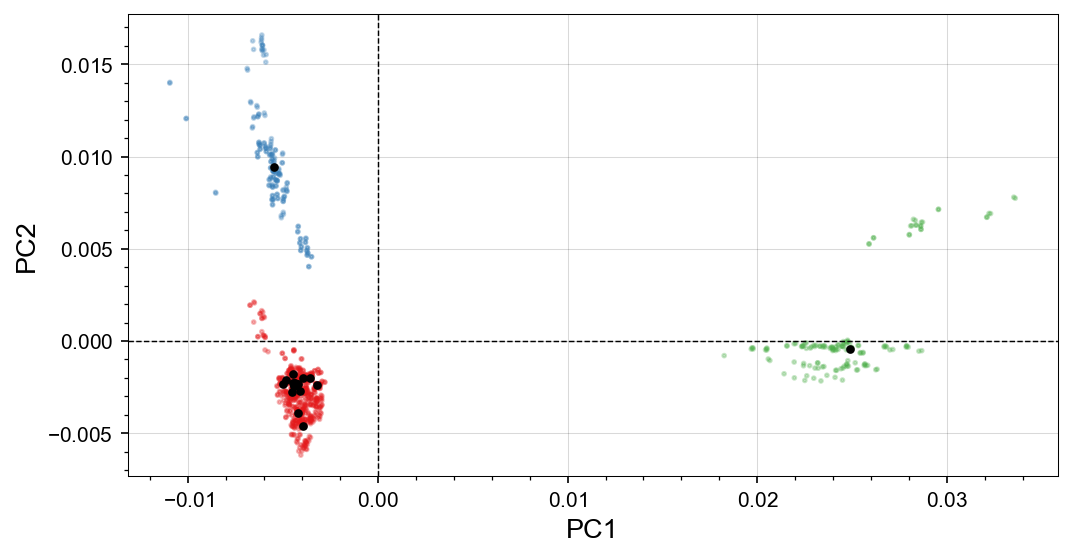

In [17]:
def get_shap_pca(trg, shaps=shaps, combs=combs, cmap='Set1'):
    df = shaps.query(f'Target=="{trg}"').drop(columns='Target')
    vals = combs.query(f'Target=="{trg}"').reset_index(drop=1).iloc[:, 1:-1]
    names = Series([', '.join([f'{k}={v}' for k, v in x.items()])
                    for _, x in vals.T.items()], name='case')
    overall_idx = set(sum([list(vals.query(' & '.join([
        f'{x}=="Overall"' for x in set(vals.columns) - {col}])).index)
                   for col in vals.columns], []))
    pca = PCA(2).fit(df)
    print(f'Explained variance: {pca.explained_variance_ratio_.sum() * 100:.1f}%')
    df = Pdf(pca.transform(df), columns=['pc1', 'pc2'])
    df = df.assign(label=names, overall=False)
    df.loc[list(overall_idx), 'overall'] = True
    df['clust'] = MeanShift().fit(df[['pc1', 'pc2']]).labels_.astype(str)
    colors = D(enumerate(sns.color_palette(cmap, df.clust.nunique()).as_hex()))
    df['color'] = df.clust.astype(int).map(colors)
    ax = pplot(size=(8, 4), dpi=150, xlab='PC1', ylab='PC2')
    ax.scatter(df.pc1, df.pc2, c=df.color, s=3, alpha=0.3)
    ax.axhline(0, ls='--', color='k', lw=0.7)
    ax.axvline(0, ls='--', color='k', lw=0.7)
    d = df.query('overall')
    ax.scatter(d.pc1, d.pc2, c='k', s=10)

x = get_shap_pca('Time'); x

Explained variance: 93.9%


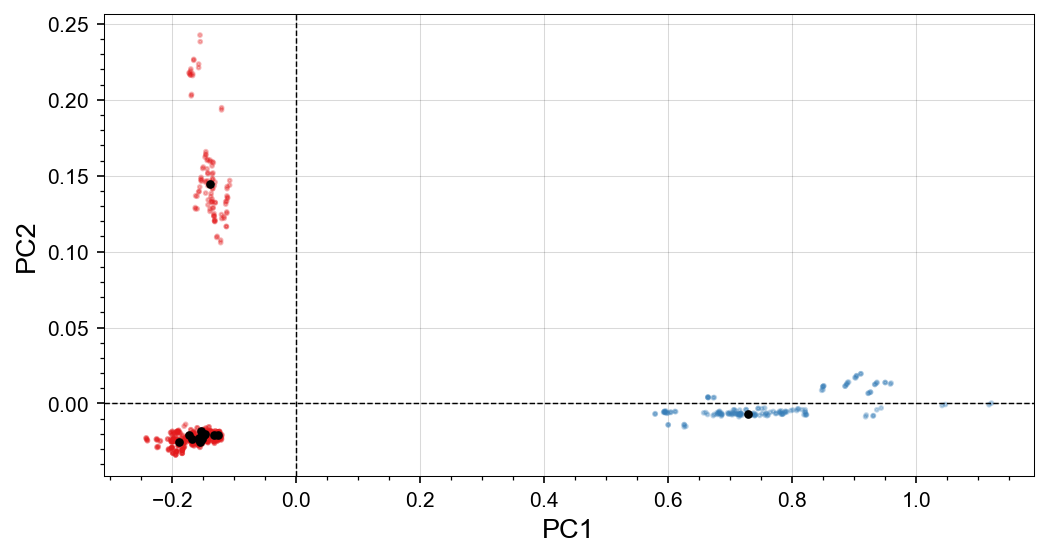

In [18]:
x = get_shap_pca('Distance'); x